# Projet n°7: Implémentez un modèle de scoring

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, recall_score, f1_score,fbeta_score, precision_recall_fscore_support
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import lightgbm as lgb

import imblearn
import pickle

from functions import *

In [2]:
from scipy.stats import randint, uniform

In [3]:
import shap

In [4]:
#Suppression des warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [6]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv("data/test_clean.csv")

In [7]:
train = category(train)
test = category(test)

### Application d'algorithme supervisé

#### Split train/test et préparation des données

In [9]:
excluded_feats = ['SK_ID_CURR', 'TARGET']
features = [f for f in train.columns if f not in excluded_feats]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    train[features], train['TARGET'], test_size=0.30, random_state=1)

In [11]:
test.shape

(48744, 178)

#### Modèle, LGBMClassifier, entraînement

In [12]:
param_test ={'num_leaves': randint(6, 40), 
             'min_child_samples': randint(100, 500), 
             'min_child_weight': [ 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50]}

In [13]:
fit_params={'callbacks':[lgb.early_stopping(500), lgb.log_evaluation(100)],
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid']
           }

In [14]:
gs = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(), 
    param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314)

In [15]:
clf = lgb.LGBMClassifier(num_leaves= 33, max_depth=-1, 
                         min_child_samples=275,
                         min_child_weight=10,
                         reg_lambda=20,
                         reg_alpha=0.1,
                         random_state=314, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.4287,
                         subsample=0.2528,
                         #class_weight='balanced',
                         #scale_pos_weight = y_train.value_counts().max()/y_train.value_counts().min(),
                         learning_rate=0.1)

In [16]:
clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 500 rounds
[100]	valid's auc: 0.773986
[200]	valid's auc: 0.775225
[300]	valid's auc: 0.775281
[400]	valid's auc: 0.774671
[500]	valid's auc: 0.77413
[600]	valid's auc: 0.772912
Early stopping, best iteration is:
[179]	valid's auc: 0.775444


LGBMClassifier(colsample_bytree=0.4287, metric='None', min_child_samples=275,
               min_child_weight=10, n_estimators=1000, n_jobs=4, num_leaves=33,
               random_state=314, reg_alpha=0.1, reg_lambda=20,
               subsample=0.2528)

###### Importance des features

<AxesSubplot:>

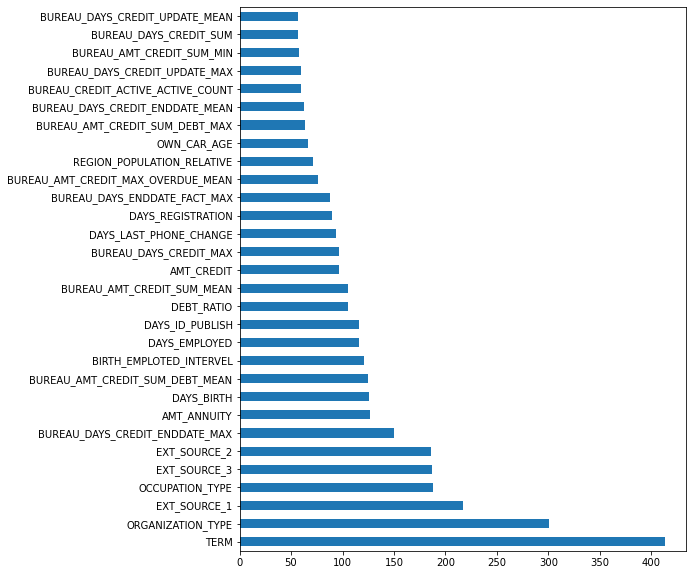

In [17]:
feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [18]:
# make a prediction for one example
y_pred_proba = clf.predict_proba(X_val)
y_pred = clf.predict(X_val)

----
#### Résultats et analyses

In [19]:
accuracy = accuracy_score(y_pred, y_val)
print('LightGBM accuracy score: {0:0.4f}'.format(accuracy))

LightGBM accuracy score: 0.9196


In [20]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84787
           1       0.56      0.03      0.06      7467

    accuracy                           0.92     92254
   macro avg       0.74      0.52      0.51     92254
weighted avg       0.89      0.92      0.89     92254



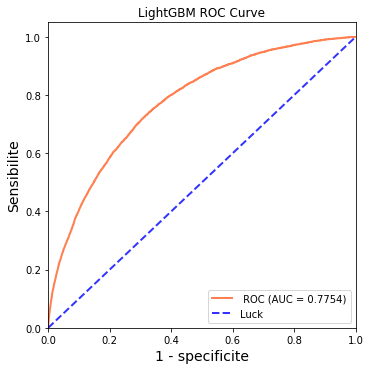

In [21]:
fig, ax  = plt.subplots(figsize=(5,5))
y_pp = clf.predict_proba(X_val)[:, 1]
[fpr_rfe, tpr_rfe, thresholds_rfe] = roc_curve(y_val, y_pp)
score = roc_auc_score(y_val, y_pp)
plt.plot(fpr_rfe, tpr_rfe, color='coral', label=' ROC (AUC = %0.4f)' % (score), lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
         label='Luck', alpha=.8)
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)
plt.savefig("support/ROC.png", bbox_inches="tight", transparent=True)

##### Choix du threshold

In [22]:
def model_eval(model, thr):
    predictions = model.predict_proba(X_val)
    classes = [1 if x >= thr else 0 for x in predictions[:, 1]]
    conf_mat = confusion_matrix(y_val, classes)
    report = classification_report(y_val, classes)
    acc, sens, spec, supp = precision_recall_fscore_support(y_val, classes, average='binary',zero_division=1)
    one_minus_spec = 1 - spec
    
    result = [conf_mat, acc, sens, spec, one_minus_spec]
    return result

In [23]:
def print_result(model):
    thr = np.arange(0.1, 0.99, 0.01)
    thr_model=[]
    acc_model=[]
    sens_model=[]
    spec_model=[]
    one_minus_spec_model=[]
    for i in thr:
        r = model_eval(model, i)
        acc_model.append(r[1])
        sens_model.append(r[2])
        spec_model.append(r[3])
        one_minus_spec_model.append(r[4])
        thr_model.append(i)
    d = {'Seuil': thr_model,
         'Accuracy': acc_model,
         'Sensitivity': sens_model,
         'Specifivity': spec_model,
         '1-Spec': one_minus_spec_model}    
    resultats = pd.DataFrame(data=d)
    graph = resultats.plot(x='Seuil', y=['Accuracy', 'Sensitivity','Specifivity'],grid=True,xlabel='Seuil',ylabel='Score')
    return resultats, graph

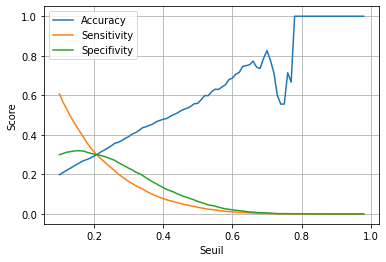

In [24]:
r, gr = print_result(clf)
plt.savefig("support/thr.png", bbox_inches="tight", transparent=True)

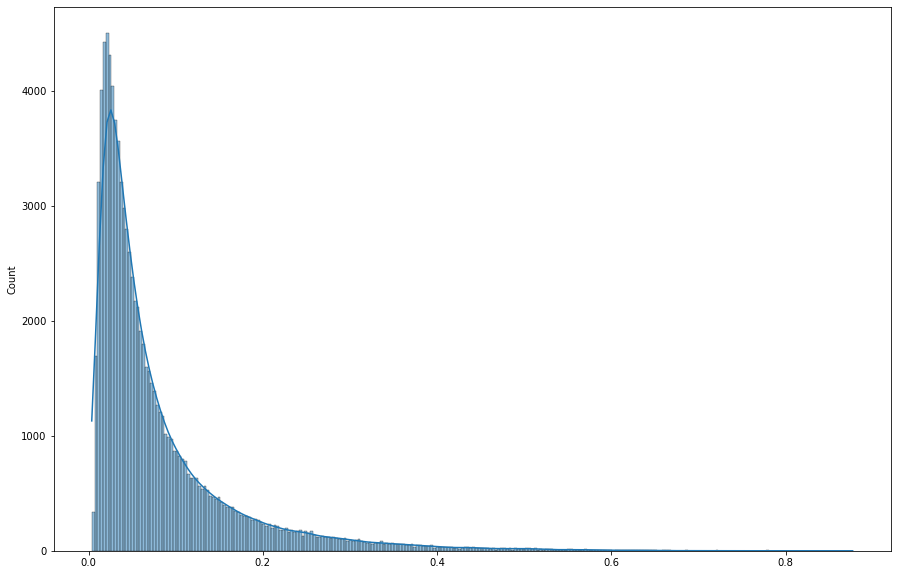

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.histplot(y_pred_proba[:, 1], kde=True)

plt.show()

In [26]:
y_val.value_counts()

0    84787
1     7467
Name: TARGET, dtype: int64

In [27]:
thr_bis = y_pred_proba[:, 1]
thr_bis = thr_bis.tolist()

In [28]:
thr_bis.sort(reverse=True)

In [29]:
thr_bis = min(thr_bis[:7467])
thr_bis

0.20764501840525437

---

In [30]:
y_pred_proba_thr = [1 if x >= 0.2 else 0 for x in y_pred_proba[:, 1]]

In [31]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84787
           1       0.56      0.03      0.06      7467

    accuracy                           0.92     92254
   macro avg       0.74      0.52      0.51     92254
weighted avg       0.89      0.92      0.89     92254



In [32]:
print(classification_report(y_val, y_pred_proba_thr))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     84787
           1       0.29      0.31      0.30      7467

    accuracy                           0.88     92254
   macro avg       0.62      0.62      0.62     92254
weighted avg       0.89      0.88      0.88     92254



In [33]:
cm = confusion_matrix(y_val, y_pred)
cm_mod = confusion_matrix(y_val, y_pred_proba_thr)

In [34]:
# Visualisation de la matrice de confusion avec une heatmap

cm_matrix = pd.DataFrame(data=cm, index=['Actual Negative:0', 'Actual Positive:1'], 
                                 columns=['Predict Negative:0', 'Predict Positive:1'])
cm_matrix_mod = pd.DataFrame(data=cm_mod, index=['Actual Negative:0', 'Actual Positive:1'], 
                                 columns=['Predict Negative:0', 'Predict Positive:1'])

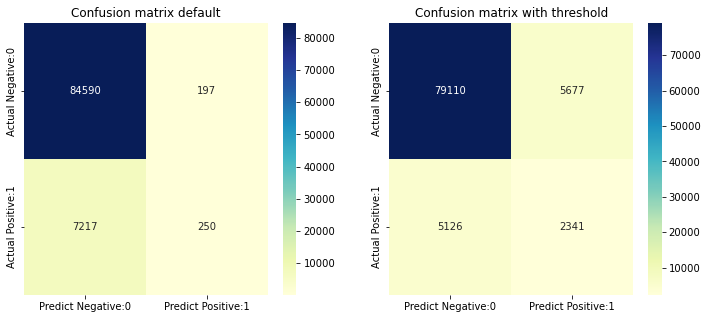

In [35]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 2, 1) # two rows, one column, first plot
ax1 = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax1.set_title("Confusion matrix default")
ax2 = fig.add_subplot(1, 2, 2) # two rows, one column, first plot
ax2 = sns.heatmap(cm_matrix_mod, annot=True, fmt='d', cmap='YlGnBu')
ax2.set_title("Confusion matrix with threshold")
plt.show()

---

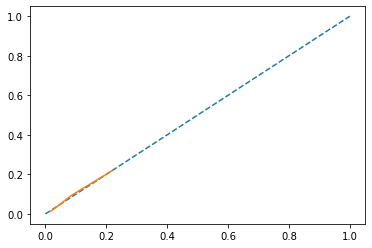

In [36]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_means, proba_means = calibration_curve(y_val, y_pred_proba[:, 1], strategy="quantile")
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

In [37]:
proba_means

array([0.01604451, 0.03045843, 0.05000833, 0.08660221, 0.21838332])

In [38]:
filename = 'data/finalized_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [39]:
fbeta_score(y_val, y_pred_proba_thr, average='binary', beta=0.5)

0.29603682440122414

----
### Explication des features avec SHAP

In [40]:
shap.initjs()

In [41]:
shap_values_train = shap.TreeExplainer(clf.booster_).shap_values(X_train)

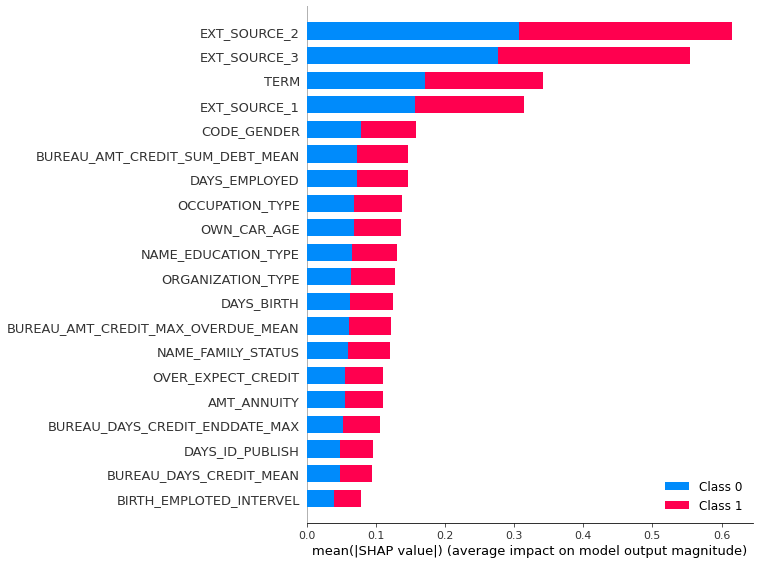

In [42]:
shap.summary_plot(shap_values_train, X_train)

In [43]:
explainer = shap.TreeExplainer(clf)
shap_values_explainer = explainer.shap_values(X_train)

In [44]:
shap.force_plot(explainer.expected_value[1], shap_values_explainer[1][0,:], X_train.iloc[0,:])

In [45]:
shap_values_test = explainer.shap_values(test.drop(columns=['SK_ID_CURR']))

In [46]:
shap.force_plot(explainer.expected_value[1], shap_values_test[1][0,:], test.drop(columns=['SK_ID_CURR']).iloc[0,:])

---
##### Création DataFrame pour graphiques Dashboard

In [47]:
features = ['SK_ID_CURR',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'TERM',
            'DAYS_EMPLOYED',
            'DAYS_BIRTH',
            'OWN_CAR_AGE',
            'CODE_GENDER',
            'ORGANIZATION_TYPE',
            'NAME_EDUCATION_TYPE',
            'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
            'TARGET']

In [48]:
df_graph = train[features]

In [49]:
df_graph.to_csv('data/features_data.csv', index=False)

In [51]:
print(lgb.__version__)

3.3.1
